In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, resize

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device}")

Running on cuda


In [2]:
# ==========================================
# 1. Augmentation Manager
# ==========================================
class AugmentationManager:
    def __init__(self, device="cpu", elastic_alpha=0.1, H=256, W=256):
        self.device = device
        self.elastic_alpha = elastic_alpha
        self.H = H
        self.W = W

    def get_elastic_transform(self):
        """Generates a random elastic deformation field."""
        grid_h, grid_w = 6, 6
        # Random offsets
        coarse_flow = (torch.rand(1, 2, grid_h, grid_w, device=self.device) - 0.5) * 2 * self.elastic_alpha
        # Upsample
        flow = F.interpolate(coarse_flow, size=(self.H, self.W), mode="bicubic", align_corners=False)
        flow = flow.permute(0, 2, 3, 1)
        return flow


def apply_warp(img_tensor, flow, device="cpu"):
    B, C, H, W = img_tensor.shape
    yy, xx = torch.meshgrid(torch.linspace(-1, 1, H, device=device), torch.linspace(-1, 1, W, device=device), indexing="ij")
    base_grid = torch.stack([xx, yy], dim=-1).unsqueeze(0)
    final_grid = base_grid - flow
    warped = F.grid_sample(img_tensor, final_grid, align_corners=False, padding_mode="border")
    return warped

In [10]:
# ==========================================
# 2. CT Simulation
# ==========================================
def add_poisson_noise(sinogram, I0=10000):
    """
    Simulates photon statistics (Poisson noise).
    sinogram: The Radon transform (attenuation map).
    I0: Source intensity (photon count). Lower = Noisier.
    """
    if I0 is None:
        return sinogram

    # 1. Beer-Lambert Law: Intensity I = I0 * exp(-attenuation)
    intensity = I0 * np.exp(-sinogram)

    # 2. Add Poisson Noise to the Intensity (Simulating detector count)
    noisy_intensity = np.random.poisson(intensity)

    # 3. Prevent log(0) errors (dead pixels)
    noisy_intensity[noisy_intensity == 0] = 1

    # 4. Recover Attenuation: mu = -ln(I / I0)
    noisy_sinogram = -np.log(noisy_intensity / I0)
    return noisy_sinogram


def simulate_sparse_ct(image_tensor, num_views, noise_intensity=None):
    """
    Full Forward Model: Image -> Radon -> Scale -> Noise -> Unscale -> FBP -> Image
    """
    img_np = image_tensor.squeeze().cpu().numpy()
    H, W = img_np.shape

    # 1. Define Angles (0 to 180 degrees)
    theta = np.linspace(0.0, 180.0, num_views, endpoint=False)

    # 2. Forward Projection (Radon)
    # sinogram = radon(img_np, theta=theta, circle=True)
    sinogram = radon(img_np, theta=theta, circle=False)

    # Raw sinogram sum is too high (~200) for exp(), causing underflow (photon starvation).
    # We scale it so max attenuation is ~4.0 (approx 98% absorption),
    # which is a realistic dynamic range for medical imaging.
    PHYSICAL_MAX_ATTENUATION = 4.0
    current_max = sinogram.max()
    scale_factor = PHYSICAL_MAX_ATTENUATION / max(current_max, 1e-6)

    # 3. Add Noise (Optional)
    if noise_intensity is not None:
        # Scale to physical range -> Add Noise -> Un-scale
        sinogram_physical = sinogram * scale_factor
        sinogram_noisy = add_poisson_noise(sinogram_physical, I0=noise_intensity)
        sinogram = sinogram_noisy / scale_factor

    # 4. Back Projection (FBP)
    # reconstruction = iradon(sinogram, theta=theta, filter_name="ramp", circle=True, output_size=max(H, W))
    reconstruction = iradon(sinogram, theta=theta, filter_name="ramp", circle=False, output_size=max(H, W))

    # 5. Clip to remove filter ringing
    reconstruction = np.clip(reconstruction, 0, 1)

    recon_tensor = torch.from_numpy(reconstruction).float().unsqueeze(0).unsqueeze(0)
    return recon_tensor, sinogram


--- Simulating 30 Views (Noise: 5000) ---


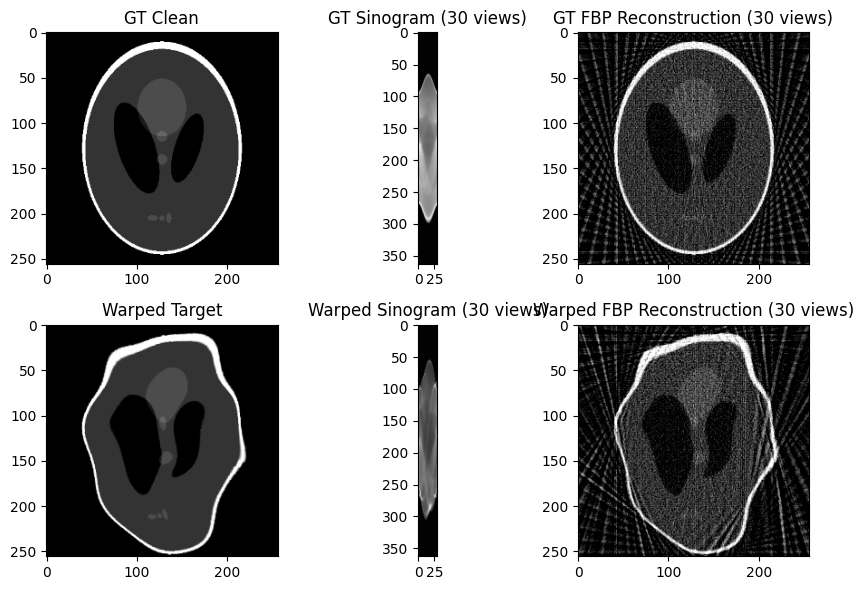

--- Simulating 60 Views (Noise: 5000) ---


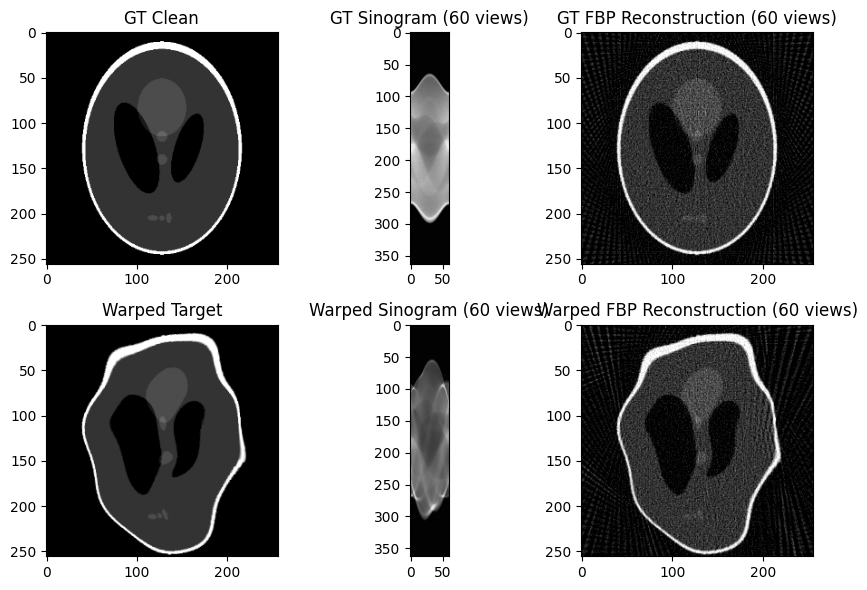

--- Simulating 90 Views (Noise: 5000) ---


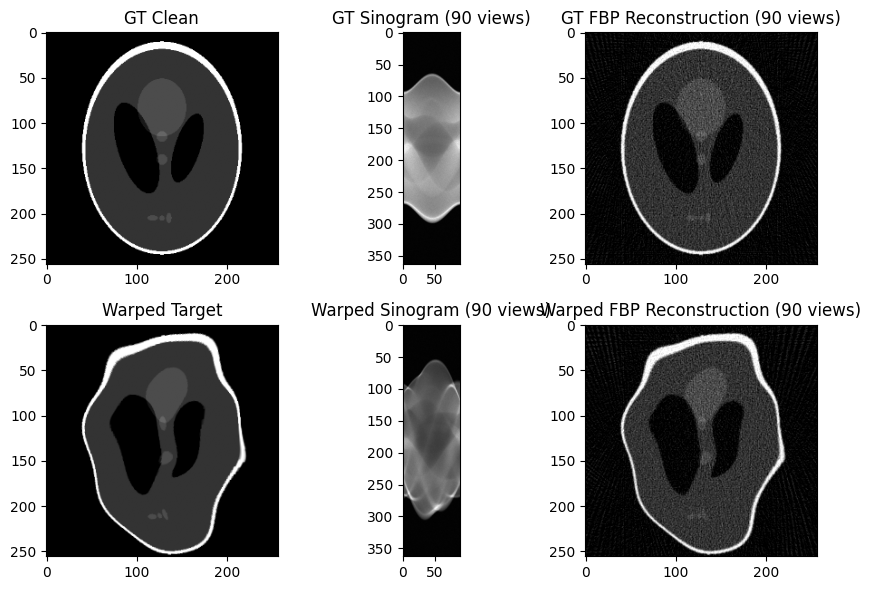

In [11]:
def run_simulation_experiment(gt_tensor, warped_gt, VIEW, NOISE_I0):
    print(f"--- Simulating {VIEW} Views (Noise: {NOISE_I0}) ---")
    # Process GT
    gt_recon, gt_sino = simulate_sparse_ct(gt_tensor, VIEW, noise_intensity=NOISE_I0)

    # Process Warped
    warped_recon, warped_sino = simulate_sparse_ct(warped_gt, VIEW, noise_intensity=NOISE_I0)

    # D. Visualize
    fig, ax = plt.subplots(2, 3, figsize=(9, 6))

    # Row 1: GT
    ax[0, 0].imshow(gt_tensor.squeeze().cpu(), cmap="gray", vmin=0, vmax=1)
    ax[0, 0].set_title("GT Clean")

    ax[0, 1].imshow(gt_sino, cmap="gray", aspect="equal")
    ax[0, 1].set_title(f"GT Sinogram ({VIEW} views)")

    ax[0, 2].imshow(gt_recon.squeeze(), cmap="gray", vmin=0, vmax=1)
    ax[0, 2].set_title(f"GT FBP Reconstruction ({VIEW} views)")

    # Row 2: Warped
    ax[1, 0].imshow(warped_gt.squeeze().cpu(), cmap="gray", vmin=0, vmax=1)
    ax[1, 0].set_title("Warped Target")

    ax[1, 1].imshow(warped_sino, cmap="gray", aspect="equal")
    ax[1, 1].set_title(f"Warped Sinogram ({VIEW} views)")

    ax[1, 2].imshow(warped_recon.squeeze(), cmap="gray", vmin=0, vmax=1)
    ax[1, 2].set_title(f"Warped FBP Reconstruction ({VIEW} views)")

    plt.tight_layout()
    plt.show()


# ==========================================
# 3. Run Experiment
# ==========================================
# A. Setup Data
gt_np = resize(shepp_logan_phantom(), (256, 256))
gt_tensor = torch.from_numpy(gt_np).float().to(device).unsqueeze(0).unsqueeze(0)

# B. Warp Data
augmentor = AugmentationManager(device=device, elastic_alpha=0.1, H=256, W=256)
flow = augmentor.get_elastic_transform()
warped_gt = apply_warp(gt_tensor, flow, device=device)

# C. Run Simulation
VIEWS = [30, 60, 90]
# NOISE_I0 = 500000  # Full Dose
NOISE_I0 = 5000  # Low Dose
# NOISE_I0 = None  # None for clean (no noise)
for VIEW in VIEWS:
    run_simulation_experiment(gt_tensor, warped_gt, VIEW, NOISE_I0)

--- Simulating 90 Views (Noise: None) ---


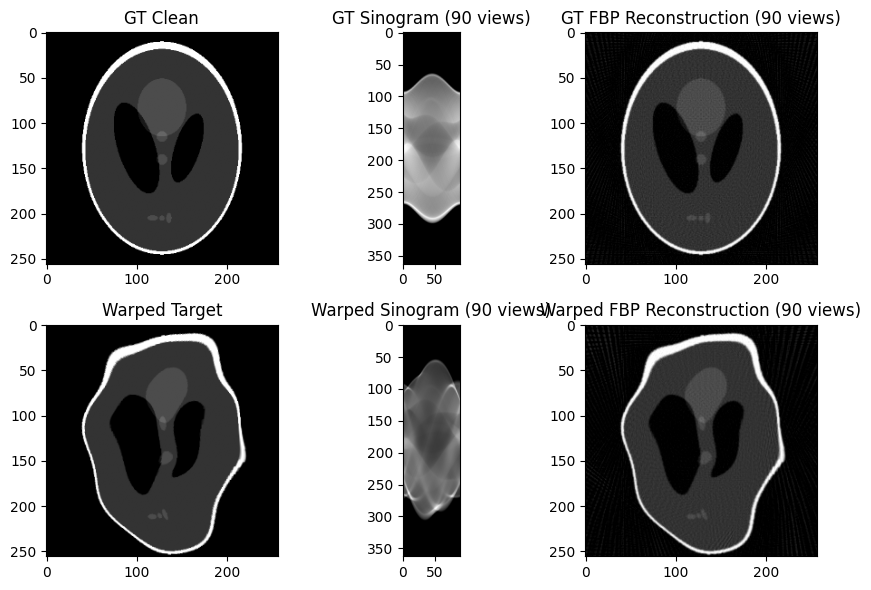

In [12]:
run_simulation_experiment(gt_tensor, warped_gt, 90, None)

--- Simulating 90 Views (Noise: 5000) ---


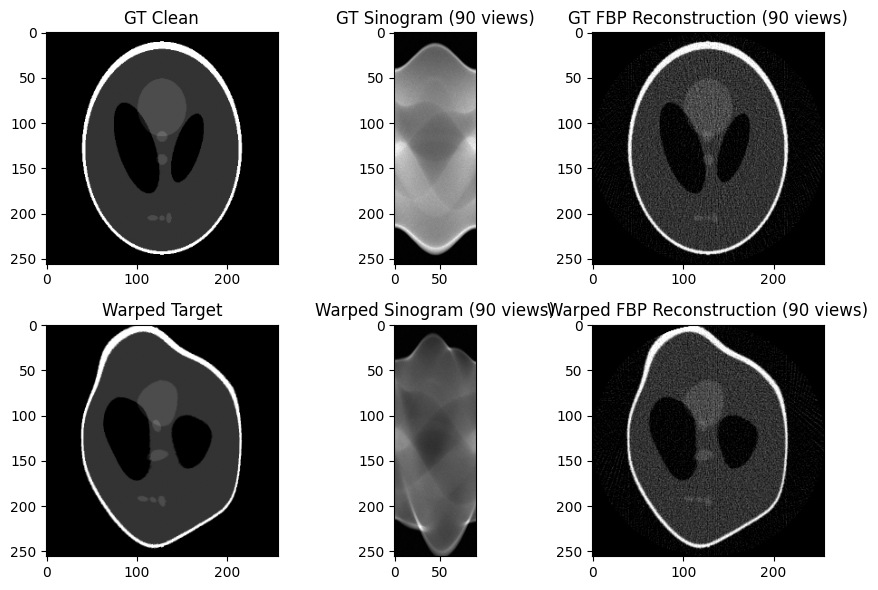

In [7]:
run_simulation_experiment(gt_tensor, warped_gt, 90, 5000)

--- Simulating 90 Views (Noise: 500000) ---


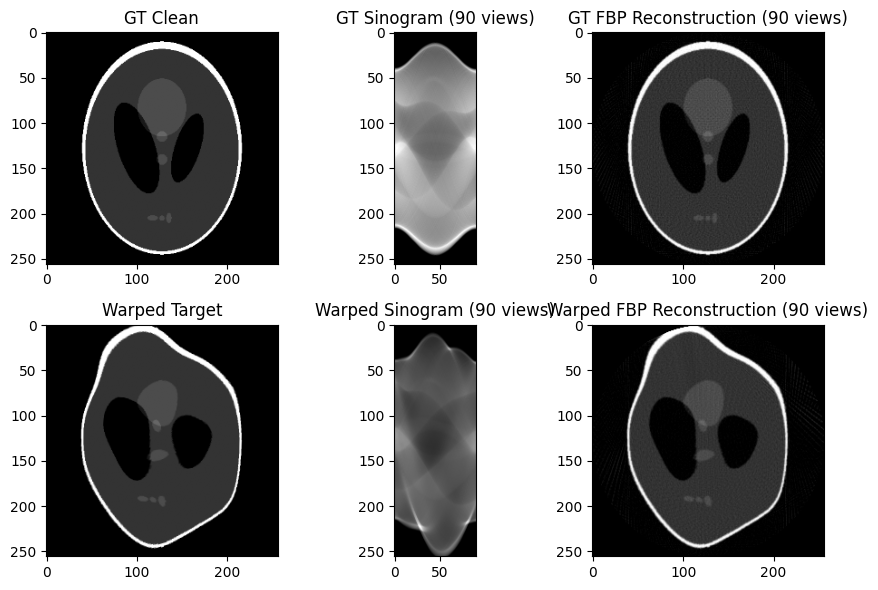

In [8]:
run_simulation_experiment(gt_tensor, warped_gt, 90, 500000)


--- Simulating 1000 Views (Noise: None) ---


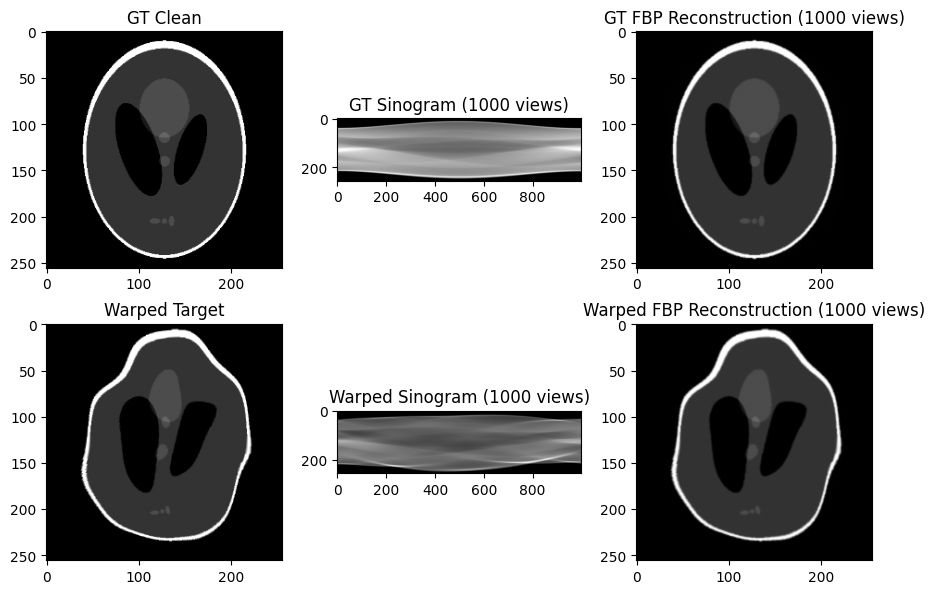

In [8]:
run_simulation_experiment(gt_tensor, warped_gt, 1000, None)

--- Simulating 30 Views (Noise: 5000) ---


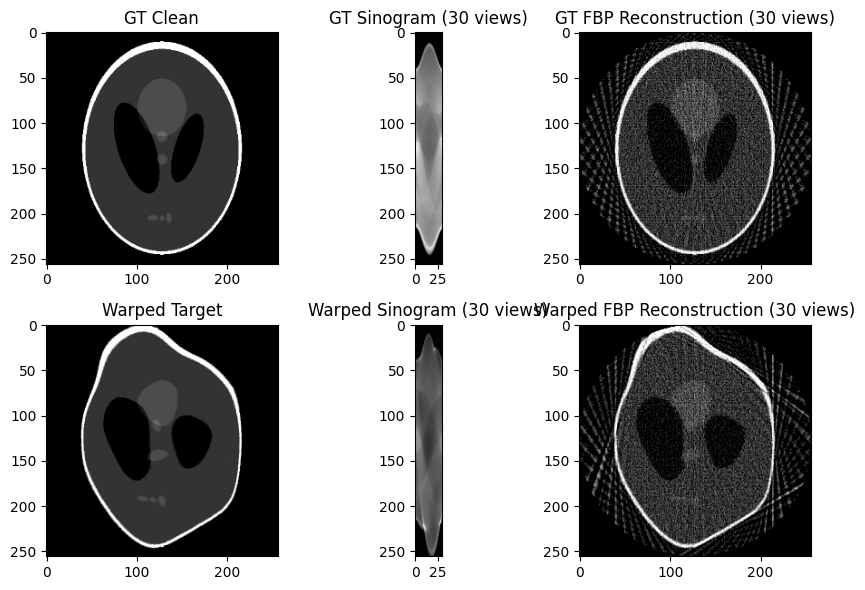

--- Simulating 60 Views (Noise: 5000) ---


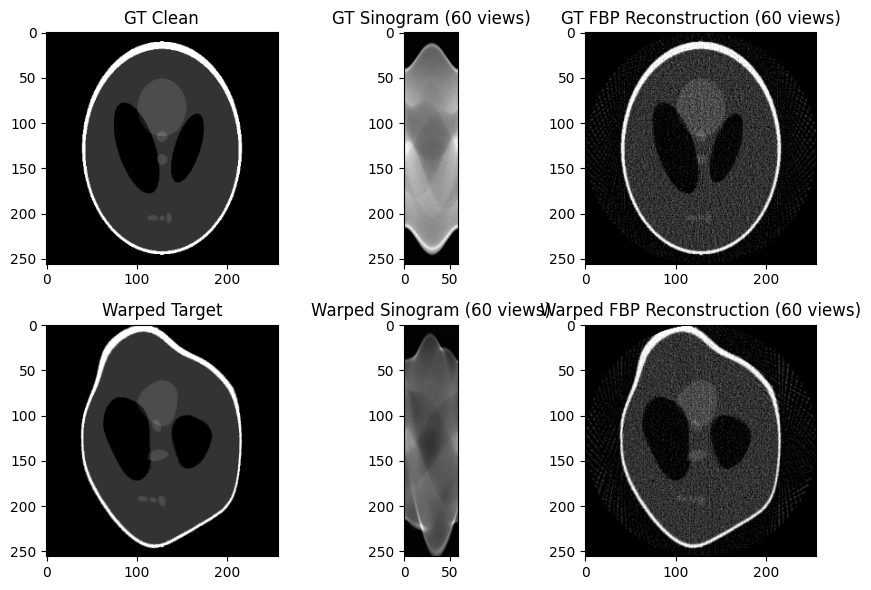

--- Simulating 90 Views (Noise: 5000) ---


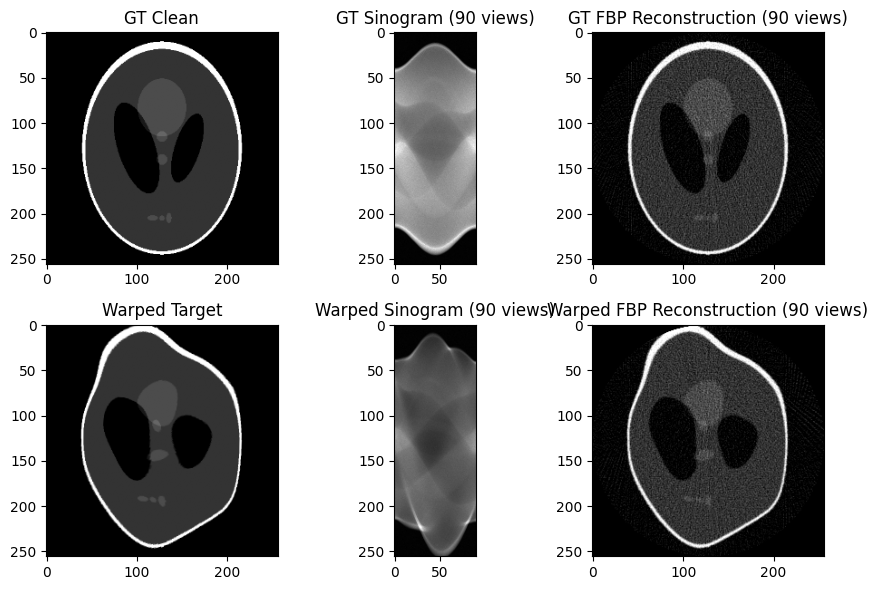

In [9]:
# C. Run Simulation
VIEWS = [30, 60, 90]
# NOISE_I0 = 500000  # Full Dose
NOISE_I0 = 5000  # Low Dose
# NOISE_I0 = None  # None for clean (no noise)
for VIEW in VIEWS:
    run_simulation_experiment(gt_tensor, warped_gt, VIEW, NOISE_I0)